# <div style="padding: 40px;color:white;margin:10;font-size:90%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://img.freepik.com/free-vector/abstract-business-professional-background-banner-design-multipurpose_1340-16856.jpg)"><b><span style='color:white'>FashionFit Attribute Extractor: Deep Learning for Trouser Fit Identification</span></b> </div>
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2
import cv2
import os
from sklearn.exceptions import ConvergenceWarning

train_labels = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-3/train.csv")
sample = pd.read_csv('/kaggle/input/extracting-attributes-from-fashion-images-3/sample_submission.csv')

train_path = "/kaggle/input/extracting-attributes-from-fashion-images-3/train"
test_path = "/kaggle/input/extracting-attributes-from-fashion-images-3/test"

import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Exploring Class Labels

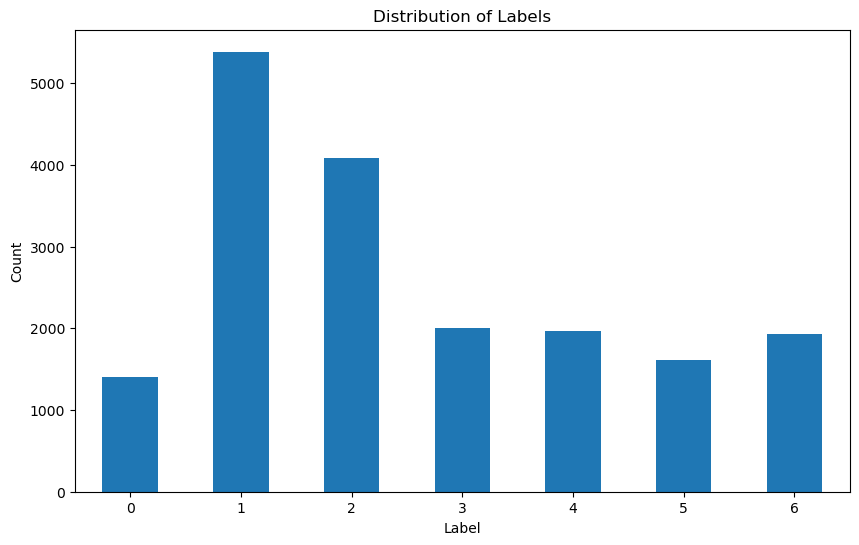

In [2]:
plt.figure(figsize=(10, 6))
train_labels['label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=0)
plt.show()

# Visulizing Images

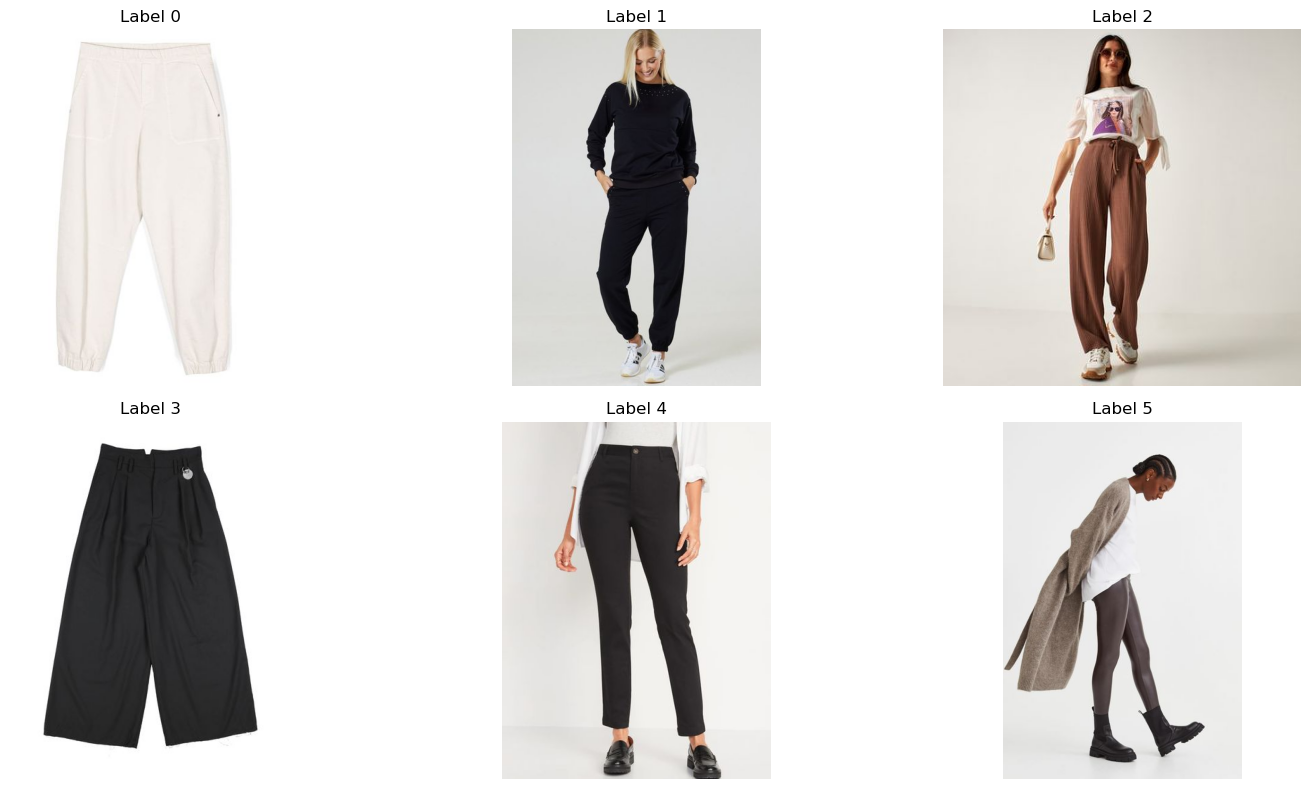

In [3]:
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(train_labels['label'].unique()):
        ax.axis("off")
        continue
    
    df_subset = train_labels[train_labels['label'] == i]
    img_path = os.path.join(train_path, df_subset['file_name'].values[0])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax.imshow(img_rgb)
    ax.set_title(f"Label {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [4]:
# from sklearn.utils.class_weight import compute_class_weight

# class_labels = np.unique(train_labels['label'])
# class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_labels['label'])
# class_weight_dict = dict(zip(class_labels, class_weights))
#class_weight_dict

# Data pre-processing

In [5]:
train_labels['label'] = train_labels['label'].astype(str)

gen  = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,         
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2], 
    horizontal_flip=True,
    validation_split=0.2,
)

batch_size = 32
img_width, img_height = 224, 224

train_generator = gen.flow_from_dataframe(
    train_labels,
    directory=train_path,
    x_col='file_name',
    y_col='label',
    subset="training",
    color_mode="rgb",
    target_size=(img_width, img_height),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

validation_generator = gen.flow_from_dataframe(
    train_labels,
    directory=train_path,
    x_col='file_name',
    y_col='label',
    subset="validation",
    color_mode="rgb",
    target_size=(img_width, img_height),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

Found 14713 validated image filenames belonging to 7 classes.
Found 3678 validated image filenames belonging to 7 classes.


# Model

In [6]:
img_width, img_height = 224, 224

# base_model = MobileNetV2(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(img_width, img_height, 3)
# )

base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)

base_model.trainable = True


model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
)

accuracy_score = model.evaluate(validation_generator)
print("Validation Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/50
459/459 [==============================] - 445s 856ms/step - loss: 1.7103 - accuracy: 0.3338 - val_loss: 2.1002 - val_accuracy: 0.2094 - lr: 1.0000e-04
Epoch 2/50
459/459 [==============================] - 324s 706ms/step - loss: 1.2143 - accuracy: 0.5531 - val_loss: 1.6088 - val_accuracy: 0.3235 - lr: 1.0000e-04
Epoch 3/50
459/459 [==============================] - 325s 708ms/step - loss: 1.0575 - accuracy: 0.6051 - val_loss: 1.5444 - val_accuracy: 0.3465 - lr: 1.0000e-04
Epoch 4/50
459/459 [==============================] - 324s 706ms/step - loss: 0.9590 - accuracy: 0.6422 - val_loss: 1.1387 - val_accuracy: 0.5354 - lr: 1.0000e-04
Epoch 5/50
459/459 [==============================] - 324s 704ms/step - loss: 0.9148 - accuracy: 0.6574 - val_loss: 1.2689 - val_accuracy: 0.4529 - lr: 1.0000e-04
Epoch 6/50
459/459 [==============================] - 324s 706ms/step - loss: 0.8815 - accuracy: 0.6659 - val_loss: 1.14

In [7]:
best_model = load_model('best_model.h5')

# Visualizing the model’s performance

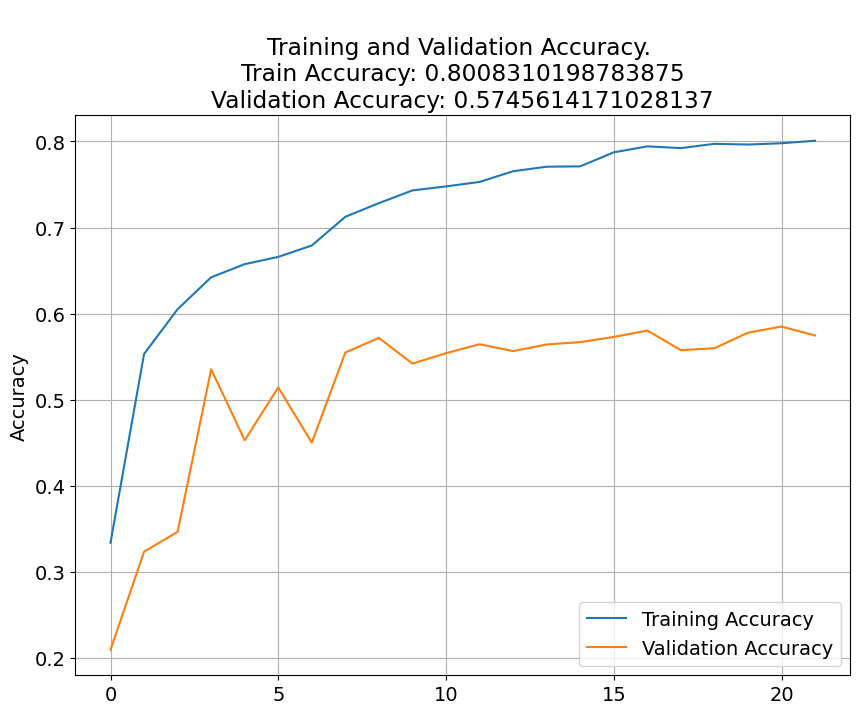

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.show()

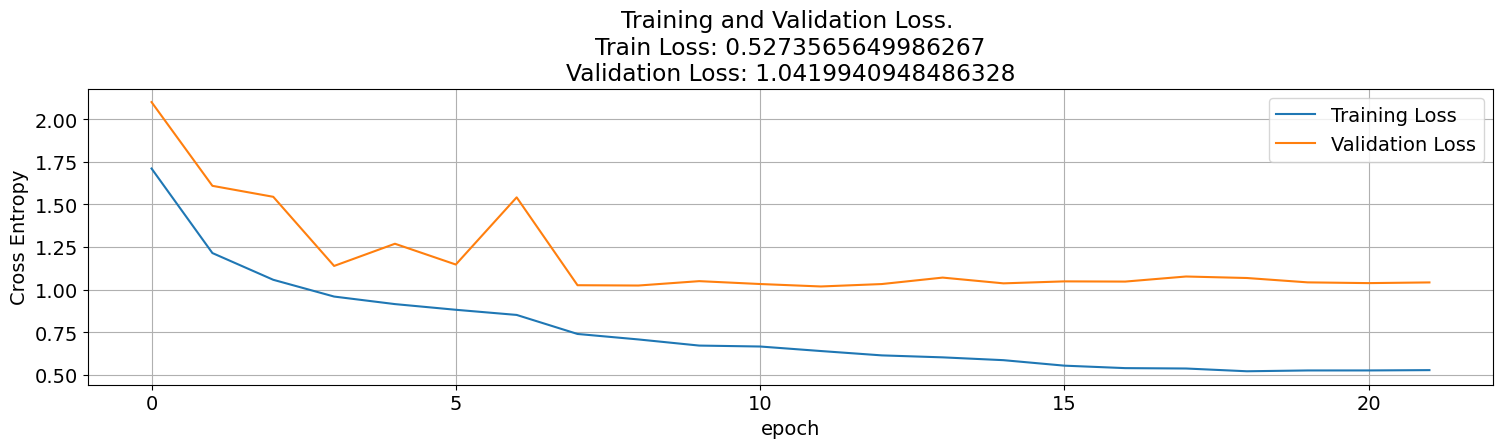

In [9]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [10]:
# predictions = []
# for image in sample.file_name:
#     img = tf.keras.preprocessing.image.load_img(test_path + '/' + image)
#     img = tf.keras.preprocessing.image.img_to_array(img)
#     img = tf.image.resize(img, (img_width, img_height))
#     img = tf.reshape(img, (-1, img_width, img_height, 3))
#     prediction = best_model.predict(img / 255)
#     predictions.append(np.argmax(prediction))

# my_submission = pd.DataFrame({'file_name': sample.file_name, 'label': predictions})
# my_submission.to_csv('submission_new.csv', index=False)
# print(my_submission.head())